In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from pytorch_model import Net
import game_parser

In [2]:
X = np.load('data/training/X.npy', allow_pickle=True)
y = np.load('data/training/y.npy', allow_pickle=True)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=True)

In [3]:
features = [
    nn.Linear(329, 50, bias=False),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.2),

    nn.Linear(50, 2, bias=False)
]

In [4]:
# hyperparameters
LR = 0.001
EPOCHS = 1
BATCH_SIZE = 128

In [5]:
train_X = torch.tensor(train_X).float().cuda()
train_y = torch.tensor(train_y).long().cuda()
test_X = torch.tensor(test_X).float().cuda()
test_y = torch.tensor(test_y).long().cuda()

train_set = TensorDataset(train_X, train_y)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# model = nn.Sequential(*features).cuda()

model = Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [7]:
# training:

losses, accuracies = [], []
val_losses, val_accs = [], []

for epoch in range(EPOCHS):
    t = tqdm(train_loader)
    for data in t:
        # TRAINING
        batch_X, batch_y = data

        model.train()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        # TESTING
        model.eval()
        test_outputs = model(test_X)
        val_loss = loss_fn(test_outputs, test_y)

        # LOGGING
        pred = torch.argmax(outputs, dim=1)
        accuracy = (pred == batch_y).float().mean()

        val_pred = torch.argmax(test_outputs, dim=1)
        val_acc = (val_pred == test_y).float().mean()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

        t.set_description(f'Train: [L: {loss:.4f}, Acc: {accuracy:.4f}] --- Test: [L: {val_loss:.4f}, Acc: {val_acc:.4f}]')

Train: [L: 0.4596, Acc: 0.7013] --- Test: [L: 0.5114, Acc: 0.7281]: 100%|██████████| 1701/1701 [00:12<00:00, 139.21it/s]


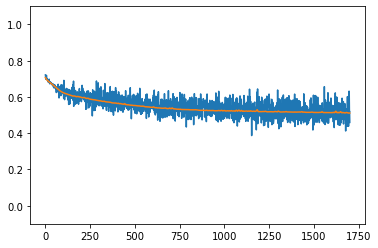

In [8]:
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(val_losses)

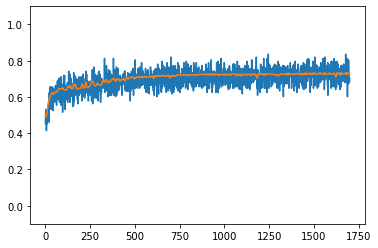

In [9]:
plt.ylim(-0.1, 1.1)
plt.plot(accuracies)
plt.plot(val_accs)

In [10]:
data = game_parser.custom_game(timestamp=0, 
champions=['Shen', 'Graves', 'Syndra', 'Senna', 'Alistar', 'Ornn', 'Nidalee', 'Orianna','Ashe','Leona'], 
blue_gold=100000, red_gold=100000, blue_exp=0, red_exp=0, bk=0, rk=0, bt=11, rt=11, bi=3, ri=3,
bm=[0,0,0,0,0,0,0], 
rm=[0,0,0,0,0,0,0])
# air earth fire water elder herald baron
data = torch.tensor(data).float().cuda().reshape(-1, 329)
model.eval()
pred = model(data)
prob = F.softmax(pred)
print(prob)

tensor([[0.5124, 0.4876]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [11]:
def save_model(path):
    torch.save(model.state_dict(), f'models/{path}')
    print(f"Model saved to 'models/{path}'!")

save_model('pepega1.pth')

Model saved to 'models/pepega1.pth'!
